# Experiment: Cohesion
To goal of cohesion is to maintain a cohesive collective whose network structure is neither too dense nor too sparse.

In [37]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt


from matplotlib import rc
from IPython.display import HTML
import matplotlib.animation as animation

import math
import numpy as np

from interaction import Interaction
from environment import Environment
from fish import Fish
from channel import Channel
from observer import Observer
import pandas as pd

from scipy.spatial import distance
from utils import generate_distortion, generate_fish, run_simulation

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Dispersion
All robots start in the same place and have too many neighbors. They disperse to decrease their number of neighbors.

Please wait patiently 5 seconds. Thanks.
It's time to say bye bye!


<IPython.core.display.Javascript object>


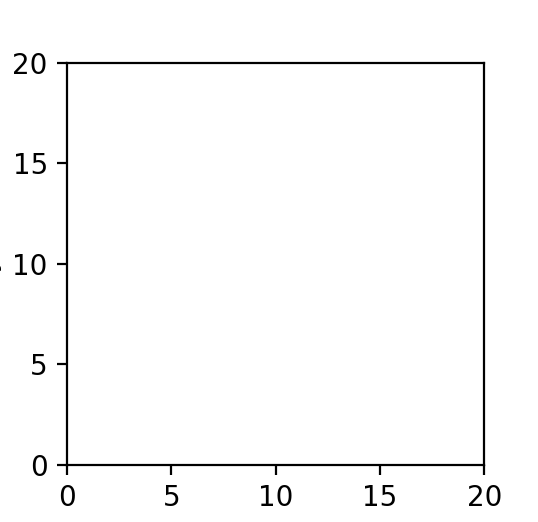

In [38]:
run_time = 5# in seconds
num_fish = 5
arena_size = 30
arena_center = arena_size / 2.0
initial_spread = 1
fish_pos = initial_spread * np.random.rand(num_fish, 2) + arena_center - initial_spread / 2.0
clock_freqs = 1
verbose = False

distortion = generate_distortion(type='none', n=arena_size)
environment = Environment(
    node_pos=fish_pos,
    distortion=distortion,
    prob_type='binary', 
    noise_magnitude=0,
    conn_thres=6,
    verbose=verbose
)
interaction = Interaction(environment, verbose=verbose)
channel = Channel(environment)

fish = generate_fish(
    n=num_fish, 
    channel=channel, 
    interaction=interaction, 
    lim_neighbors=[2,8],
    neighbor_weights=1.0,
    fish_max_speeds=1,
    clock_freqs=clock_freqs,
    verbose=verbose
)
channel.set_nodes(fish) 

observer = Observer(fish=fish, environment=environment, channel=channel)
run_simulation(fish=fish, observer=observer, run_time=run_time, dark=True, white_axis=False, no_legend=True)
observer.animate_plot()

In [ ]:
neighbors= {1:np.array([-0.13265279,  0.02321057]), 2: np.array([-0.2005765 , -0.18300661]), 
            6: np.array([-0.12874934, -0.52024419]), 4: np.array([ 0.39604864, -0.45861362]), 
            5: np.array([-0.18143229,  0.00677317]), 7: np.array([ 0.08187928, -0.44985067]),
            8: np.array([-0.15155937, -0.0875348 ]), 16: np.array([-0.01548467,  0.03539648]), 
            15: np.array([ 0.23504852, -0.08975046])}
#change it to pandas for easier manipulation 
df = pd.DataFrame.from_dict(neighbors,orient = 'index', columns=['X', 'Y'])
df['dist'] = np.sqrt( (df.X)**2 + (df.Y)**2)
df['angles']= np.degrees(np.arcsin(df.Y/df.dist))
print(df)
df.sort_values(['dist'])
i = df[(df['Y'] > 0 )& (df['X'] > 0)]
ii = df[(df['Y'] > 0 )& (df['X'] < 0)]
iii= df[(df['Y'] < 0) & (df['X'] < 0)]
iv = df[(df['Y'] < 0) & (df['X'] > 0)]

xr=xl=yl=yr =0.0
step_size = 0.05
quadrants = [i,ii,iii,iv]
x = []
y = []
a = []
for q in quadrants: 
    q.sort_values(['dist'])
    if(len(q)>0):
        x.append(q['X'].values[0]-d)
        y.append(q['Y'].values[0]-d)
        a.append(q['angles'].values[0])
        #neig_clique.append([q['X'].values[0]-d,q['Y'].values[0]-d])
    else:
        x.append(float('-inf'))
        y.append(float('-inf'))
        a.append(float('-inf'))
print(x,y,a)
#function to ensure that the closest neighbors are getting even closer 
print(np.degrees(np.arcsin(1/np.sqrt(2))))
#TODO
#Function align 
#Function detect neighbors
#Function limit
#Function measure
#

### Aggregation in a counterclockwise curl
They robots start spread out and have too few neighbors. They aggregate to increase their number of neighbors. While doing so, they are affacted by a distortion of the type of a counterclockwise curl.

In [ ]:
run_time = 10 # in seconds
num_fish = 50
arena_size = 30
arena_center = arena_size / 2.0
initial_spread = 25
fish_pos = initial_spread * np.random.rand(num_fish, 2) + arena_center - initial_spread / 2.0
clock_freqs = 1
verbose = False

distortion = generate_distortion(type='curl', n=arena_size)
environment = Environment(
    node_pos=fish_pos,
    distortion=distortion,
    prob_type='binary',
    noise_magnitude=0,
    conn_thres=10,
    verbose=verbose
)
interaction = Interaction(environment, verbose=verbose)
channel = Channel(environment)

fish = generate_fish(
    n=num_fish, 
    channel=channel, 
    interaction=interaction, 
    lim_neighbors=[math.inf,math.inf],
    neighbor_weights=1.0,
    fish_max_speeds=1,
    clock_freqs=clock_freqs,
    verbose=verbose
)
channel.set_nodes(fish)

observer = Observer(fish=fish, environment=environment, channel=channel)
run_simulation(fish=fish, observer=observer, run_time=run_time, dark=True, white_axis=False, no_legend=True)

### Aggregation and migration
The robots start dispersed and gather first to then migrate from left to right. This is similar to salmons who come from different places in the ocean and then swim up their rivers of origin for reproduction.

In [ ]:
from events import Move

run_time = 20 # in seconds
num_fish = 25
arena_size = 30
arena_center = arena_size / 2.0
initial_spread = 10
fish_pos = np.zeros((num_fish,2))
fish_pos[:,0] = np.random.rand(num_fish) * initial_spread
fish_pos[:,1] = np.random.rand(num_fish) * initial_spread + arena_center - initial_spread/2
clock_freqs = 1
verbose = False

distortion = generate_distortion(type='none', n=arena_size)
environment = Environment(
    node_pos=fish_pos,
    distortion=distortion,
    prob_type='binary',
    noise_magnitude=0.2,
    conn_thres=10,
    verbose=verbose
)
interaction = Interaction(environment, verbose=verbose)
channel = Channel(environment)

fish = generate_fish(
    n=num_fish, 
    channel=channel, 
    interaction=interaction, 
    lim_neighbors=[math.inf,math.inf],
    neighbor_weights=1.0,
    fish_max_speeds=1,
    clock_freqs=clock_freqs,
    verbose=verbose
)
channel.set_nodes(fish)

observer = Observer(fish=fish, environment=environment, channel=channel)

migrate = Move(1,0)
observer.instruct(event=migrate, rel_clock=0, fish_all=True)

run_simulation(fish=fish, observer=observer, run_time=run_time, dark=True, white_axis=False, no_legend=True, no_star=True)